/home/rizvan/.local/lib/python3.9/site-packages/iminuit/util.py:183: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Number of chi^2 function calls: 724
Number of degrees of freedom in fit: 463
chi^2 value at minimum: 1006.4274197724066
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'mwebv', 'mwr_v']
best-fit values: [ 9.83141786e-02  5.82653470e+04  8.06785754e-08 -5.71871970e-01
 -7.21424043e-02  3.00000000e-02  3.10000000e+00]


covariance [[2.7292548600126566e-14, -1.2461927332452844e-13, 3.5292682055134944e-20, -1.3323290074173446e-12, -8.339374736685796e-13], [-1.2461927332452844e-13, 8.149548843111787e-09, -2.5685434069029915e-15, 8.32620528218712e-08, 5.677978718480518e-08], [3.5292682055134944e-20, -2.5685434069029915e-15, 8.077285058969899e-19, -5.267514460465506e-11, -6.82052628533567e-12], [-1.3323290074173446e-12, 8.32620528218712e-08, -5.267514460465506e-11, 0.008730392916178194, 0.0002768381125489028], [-8.339374736685796e-13, 5.677978718480518e-08, -6.82052628533567e-12, 0.0002768381125489028, 0.00010509946056296573]]


time_covariance 5.650520324707031e-05


json {"model parameters":

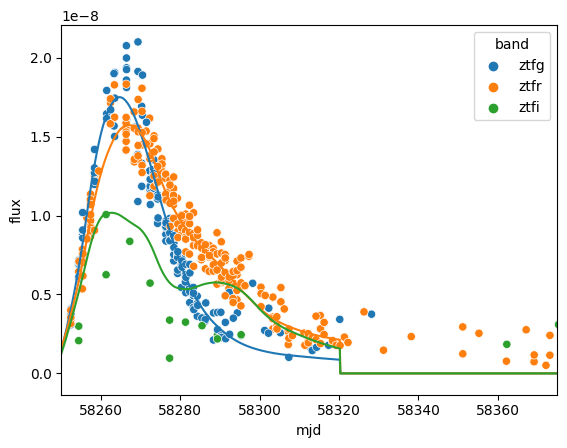

In [14]:
import sncosmo
import sfdmap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
import requests
import seaborn as sns
import json

import time
import selenium
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from Oid_to_ref import oid_to_ref
from Models_to_parameters import models_to_parameters


def mag_flux(data, ref):
    flux = [10 ** (-0.4 * a) - 10 ** (-0.4 * b[0]) for a, b in zip(data['mag'], ref)]
    fluxerr = [((-0.4 * np.log(10) * 10 ** (-0.4 * a) * c) ** 2 + 
                        (-0.4 * np.log(10) * 10 ** (-0.4 * b[0]) * b[1]) ** 2) ** 0.5  for a, b, c, in zip(data['mag'], ref, data['magerr'])]
    return (flux, fluxerr)


def print_params(result):
    print("Number of chi^2 function calls:", result.ncall)
    print("Number of degrees of freedom in fit:", result.ndof)
    print("chi^2 value at minimum:", result.chisq)
    print("model parameters:", result.param_names)
    print("best-fit values:", result.parameters)
    print('\n')
    
    start = time.time()
    print("covariance", result.covariance.tolist())
    end = time.time() - start 
    print('\n')
    print('time_covariance', end)
    print('\n')
    return json.dumps({'model parameters': dict(zip(result.param_names, result.parameters)), 
                       'degrees of freedom': result.ndof, 'covariance': result.covariance.tolist(), 'chi^2': result.chisq})

    
def plot(data, fitted_model, result, name_model, a, b, dx, filters):
    #fig = sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)
    #fig.savefig('Fits/' + str(oid) + '_' + name_model)
    #if str(type(filters))=='str': 
        #filters = [filters]
    segment = np.linspace(a, b, dx)
    df_buf = data.to_pandas()
    df = df_buf[df_buf.band.isin(filters)==True]
    
    filters_sorted = []
    for i in df['band'].unique():
        if i in filters:
            filters_sorted.append(i)
    filters = filters_sorted
    
    sns.scatterplot(data=df, x='mjd', y='flux', hue='band')
    for i in filters:
        predicts = [fitted_model.bandflux(i, [point], 8.9, 'ab') for point in segment]#bandflux(self, band, time, zp, zpsys)
        #plt.scatter(data['mjd'], data['flux'], s=8, color='blue')
        plt.plot(segment, predicts)
        plt.xlim(a, b)
    plt.show()

    
def fit(data, name_model, ebv, a, b, dx, filters):
    #ebv = 0.03
    dust = sncosmo.CCM89Dust()
    model = sncosmo.Model(source=name_model, effects=[dust], effect_names=['mw'], effect_frames=['obs'])
    model.set(mwebv=ebv)
    result, fitted_model = sncosmo.fit_lc(data, model, models_to_parameters[name_model], bounds={'z':(0.01, 0.3)})
    return result, fitted_model

    
def give_chrome_option(folder_path):
    chromeOptions = webdriver.ChromeOptions() #setup chrome option
    prefs = {"download.default_directory" : folder_path,
           "download.prompt_for_download": False,
           "download.directory_upgrade": True}  #set path
    chromeOptions.add_experimental_option("prefs", prefs) #set option
    #chromeOptions.add_argument("--headless")
    return chromeOptions


def get_data(ra, dec, radius):
    
    #/api/v3/data/latest/oid/full/json?oid=830202400008402
    #BASE_URL = 'http://db.ztf.snad.space/api/v3/data/latest/oid/full/json?oid=' + str(oid)
    BASE_URL = 'http://db.ztf.snad.space/api/v3/data/latest/circle/full/json?ra=' + str(ra) + '&dec=' + str(dec) + '&radius_arcsec=' + str(radius)
    json = requests.get(f"{BASE_URL}").json()
    data = []
    for i in json.keys():
        buf_df = pd.DataFrame.from_records(json[i]['lc'])
        buf_df['band'] = json[i]['meta']['filter']
        buf_df['oid'] = int(i)
        data.append(buf_df)
    df = pd.concat([i for i in data], axis=0, sort=False, ignore_index=True)
    folder_path = f'home/Downloads'
    driver = webdriver.Chrome(options = give_chrome_option(folder_path))
    url = "https://ztf.snad.space/dr17/view/" + str(df['oid'][1])
    driver.get(url)
    time.sleep(10)
    base = driver.find_element(By.ID, "summary")
    #ebv = float(base.text.split('\n')[5][-4:])
    for i in base.text.split('\n'):
        if i.split(':')[0]=='Extinction':
            ebv = float(i[-4:])
    base = driver.find_element(By.XPATH, '//*[@id="light-curve-brightness"]/label[4]/input').click()
    #base = driver.find_element(By.XPATH, "//*[@id='ref-mag']").get_attribute('text')
    #print(base)
    return df, ebv


def aproximate(ra, dec, radius, name_model, a, b, dx, filters):
    #data = pd.read_csv(str(oid) + ".csv")
    data, ebv = get_data(ra, dec, radius)
    #ref = data['oid'].map(oid_to_ref[oid])
    for i in data['oid'].unique():
        if i in oid_to_ref.keys():
            ref = data['oid'].map(oid_to_ref[i])
    #data['mag_d'] = [-2.5 * np.log10(10 ** (-0.4 * a) - 10 ** (-0.4 * b[0])) for a, b in zip(data['mag'], ref)]
    data['flux'], data['fluxerr'] = mag_flux(data, ref)
    data['zp'] = 8.9
    data['zpsys'] = 'ab'
    data['band'] = data['band'].str.replace('z', 'ztf')
    data = Table.from_pandas(data)
    dust = sncosmo.CCM89Dust()
    result, fitted_model = fit(data, name_model, ebv, a, b, dx, filters)
    result_json = print_params(result)
    print('json', result_json)
    plot(data, fitted_model, result, name_model, a, b, dx, filters)

#aproximate(633207400004730, 'salt2')
aproximate(263.37726, 51.25848, 1, 'salt2', 58250, 58375, 1000, ['ztfg', 'ztfi', 'ztfr'])